In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os 
from datetime import datetime

## import our module 
import cifar10

# show all the output 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Speficy Parameters**

In [2]:
from cifar10 import img_size, num_channels, num_classes
img_size_cropped = 24             ## For Data Augmentations
img_size
num_channels
num_classes

32

3

10

## 1. Download and Import Data

In [3]:
data_path = "data/CIFAR-10/"
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
cifar10.maybe_download_and_extract(url=data_url, download_dir=data_path)

Data has apparently already been downloaded and unpacked.


In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
images_train, cls_train, labels_train = cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [6]:
#images_train = images_train[0:100,:,:,:]
#images_test = images_test[0:100,:,:,:]
#labels_train = labels_train[0:100,:]
#labels_test = labels_test[0:100,:]

In [7]:
# Check the data shape 
images_train.shape
images_test.shape
labels_train.shape   ##label_train and test_train is the one-hot coded label 
labels_test.shape

(100, 32, 32, 3)

(100, 32, 32, 3)

(100, 10)

(100, 10)

## 2. Define Different help-Functions

#### 1. For Data Augmentation

In [8]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image


def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

#### 2. For get the cross entropy and the accuracy: 

In [9]:
## The teo functions are from script for class
def compute_cross_entropy(logits, y):
    # Compute the average cross-entropy across all the examples.
    numerical_instability_example = 0
    if numerical_instability_example:
        y_pred = tf.nn.softmax(logits, name='y_pred') # the predicted probability for each example.
        cross_ent = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), reduction_indices=[1]))
    else:
        sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
        cross_ent = tf.reduce_mean(sm_ce, name='cross_ent')
    return cross_ent

def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return accuracy

#### 3. For better training the network
#### But we don't use it for the new version

#### 4.  For defining the Network

In [10]:
def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

def avgpool(x, k = 3, s = 2, p = 'SAME'):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding= p)

def dropout(x):
    """simple wrapper for tf.nn.dropout with dropout ratio 0.5"""
    return tf.nn.dropout(x, 0.5)
    

def compute_logits(x):
    x_image = tf.reshape(x, [-1, img_size_cropped, img_size_cropped, 3])
    # conv1 / relu1
    W_conv1 = tf.get_variable('W_conv1', shape = [5, 5, 3, 192])
    b_conv1 = tf.get_variable('b_conv1', shape = [192],)
    h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
    
    # cccp1 / relu_cccp1
    W_cccp1 = tf.get_variable('W_cccp1', shape = [1, 1, 192, 160])
    b_cccp1 = tf.get_variable('b_cccp1', shape = [160])
    h_cccp1 = tf.nn.relu(tf.add(conv(h_conv1, W_cccp1), b_cccp1))
    
    # cccp2 / relu_cccp2
    W_cccp2 = tf.get_variable('W_cccp2', shape = [1, 1, 160, 96])
    b_cccp2 = tf.get_variable('b_cccp2', shape = [96])
    h_cccp2 = tf.nn.relu(tf.add(conv(h_cccp1, W_cccp2), b_cccp2))
    
    #print(h_cccp2)
    h_pool1 = maxpool(h_cccp2)
    # drop3
    h_drop3 = dropout(h_pool1)
    # conv2 / relu2
    W_conv2 = tf.get_variable('W_conv2', shape = [5, 5, 96, 192])
    b_conv2 = tf.get_variable('b_conv2',shape = [192])
    h_conv2 = tf.nn.relu(tf.add(conv(h_drop3, W_conv2), b_conv2))
    
    # cccp3 / relu_cccp3
    W_cccp3 = tf.get_variable('W_cccp3', shape = [1, 1, 192, 192])
    b_cccp3 = tf.get_variable('b_cccp3', shape = [192])
    h_cccp3 = tf.nn.relu(tf.add(conv(h_conv2, W_cccp3), b_cccp3))
    
    # cccp4 / relu_cccp4
    W_cccp4 = tf.get_variable('W_cccp4', shape = [1, 1, 192, 192])
    b_cccp4 = tf.get_variable('b_cccp4',shape = [192])
    h_cccp4 = tf.nn.relu(tf.add(conv(h_cccp3, W_cccp4), b_cccp4))
    # poo2
    h_pool2 = avgpool(h_cccp4)
    # drop6
    h_drop6 = dropout(h_pool2)
    
    # conv3 / relu3
    W_conv3 = tf.get_variable('W_conv3', shape = [3, 3, 192, 192])
    b_conv3 = tf.get_variable('b_conv3',shape = [192],)
    h_conv3 = tf.nn.relu(tf.add(conv(h_drop6, W_conv3), b_conv3))
    
    # cccp5 / relu_cccp5
    W_cccp5 = tf.get_variable('W_cccp5', shape = [1, 1, 192, 192])
    b_cccp5 = tf.get_variable('b_cccp5', shape = [192])
    h_cccp5 = tf.nn.relu(tf.add(conv(h_conv3, W_cccp5), b_cccp5))
    
    # cccp6 / relu_cccp6
    W_cccp6 = tf.get_variable('W_cccp6', shape = [1, 1, 192, 10])
    b_cccp6 = tf.get_variable('b_cccp6',shape = [10])
    h_cccp6 = tf.nn.relu(tf.nn.bias_add(conv(h_cccp5, W_cccp6), b_cccp6))
    
    # pool3
    h_pool3 = avgpool(h_cccp6, 6, 1, 'VALID')
    output_reshaped = tf.reshape(h_pool3, [-1,10])

    return output_reshaped,h_conv1,h_cccp1,h_cccp2,h_pool1,h_conv2,h_pool2,h_cccp3,h_cccp4,h_conv3,h_cccp5,h_cccp6,h_pool3

#### 5. for Beting the random batch

In [11]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)
    
    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx,:,:,:]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

## 3. Build and Train the Network

In [12]:
len(images_train)

100

In [13]:
now = datetime.now()

dir_name = 'log_{0}_{1}'.format(now.month,now.day)
export_dir = 'savedmodel_{0}_{1}_{2}_{3}'.format(now.month,now.day,now.hour,now.second)

batch_size = 128
num_iterations = 20000
opt_method = 'adam'

**Randomly Chroped the test and training image**

In [14]:
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)

with tf.Graph().as_default():
    
    global_step = tf.train.get_or_create_global_step()

    # Get images and labels for CIFAR-10.
    # Force input pipeline to CPU:0 to avoid operations sometimes ending up on
    # GPU and resulting in a slow down.
    
    with tf.device('/cpu:0'):
        # We build the model here as before
        x= tf.placeholder(tf.float32, shape=[None,32,32, num_channels], name='x')
        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
        
        images = x
        images = pre_process(images=images, training=True)
        
        with tf.name_scope('model'):
            logits,conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3 = compute_logits(images)

            print('conv1:',conv1.shape,
                  'cccp1:',cccp1.shape,
                  'cccp2:',cccp2.shape,
                  'pool1:',pool1.shape,
                  'conv2:',conv2.shape,
                  'pool2:',pool2.shape,
                  'conv3:',conv3.shape,
                  'cccp5:',cccp5.shape)
            
        with tf.name_scope('loss'):
            loss = compute_cross_entropy(logits=logits, y=y_true)
        with tf.name_scope('accuracy'):
            accuracy = compute_accuracy(logits=logits, y=y_true)
            
        
        with tf.name_scope('opt'):   
            if opt_method == 'sgd':
                opt = tf.train.GradientDescentOptimizer(0.5)
            elif opt_method == 'rms':
                opt = tf.train.RMSPropOptimizer(.001)
            elif opt_method == 'adam':
                #var_list1 = [W_conv1, b_conv1, W_cccp1, b_cccp1, W_cccp2, b_cccp2,
                #            W_conv2, b_conv2, W_cccp3, b_cccp3, W_cccp4, b_cccp4,
                #            W_conv3, b_conv3, W_cccp5, b_cccp5]
                #var_list2 = [W_cccp6, b_cccp6]
                #train_op1 = tf.train.AdamOptimizer(0.1).minimize(loss, var_list = var_list1)
                #train_op2 = tf.train.AdamOptimizer(0.01).minimize(loss, var_list = var_list2)
                #train_step = tf.group(train_op1, train_op2)
                opt = tf.train.AdamOptimizer(1e-4)
            train_step = opt.minimize(loss)
                
        with tf.name_scope('summaries'):
            # create summary for loss and accuracy
            tf.summary.scalar('loss', loss) 
            tf.summary.scalar('accuracy', accuracy)
            # create summary for logits
            tf.summary.histogram('logits', logits)
            # create summary for input image
            tf.summary.image('input', tf.reshape(images, [-1,img_size_cropped,img_size_cropped, num_channels]))
            summary_op = tf.summary.merge_all()
    
        saver = tf.train.Saver()    ##Save the model
        
        sess = tf.Session()
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
        
        sess.run(tf.global_variables_initializer())
    
        for i in range(num_iterations):
            X_batch, y_batch = random_batch()
            
            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y_true: y_batch})
            
                
            # write the summary output to file
            if i%200==0:
                summary_writer_train.add_summary(summary, i)
                    
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y_true: y_batch})
                print("\rStep {0:3d}: training accuracy {1:0.4f}".format(i, train_error), flush=True)
                
                X_batch2 = images_test
                y_batch2 = labels_test
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch2, y_true:y_batch2})
                print("\rStep {0:3d}: val accuracy {1:0.4f}".format(i, val_error), flush=True)
                summary_writer_val.add_summary(summary, i)
                saver.save(sess, './model/model_iter', global_step=i)
                
        # Save the final model
        save_path = saver.save(sess, "./model/model.ckpt")
        builder.add_meta_graph_and_variables(sess,["foo-tag"])
builder.save()

conv1: (?, 24, 24, 192) cccp1: (?, 24, 24, 160) cccp2: (?, 24, 24, 96) pool1: (?, 12, 12, 96) conv2: (?, 12, 12, 192) pool2: (?, 6, 6, 192) conv3: (?, 6, 6, 192) cccp5: (?, 6, 6, 192)


<tf.Tensor 'summaries/loss:0' shape=() dtype=string>

<tf.Tensor 'summaries/accuracy:0' shape=() dtype=string>

<tf.Tensor 'summaries/logits:0' shape=() dtype=string>

<tf.Tensor 'summaries/input:0' shape=() dtype=string>

Step   0: training accuracy 0.1667
Step   0: val accuracy 0.0600


'./model/model_iter-0'

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'savedmodel_12_13_21_2\\saved_model.pb'


b'savedmodel_12_13_21_2\\saved_model.pb'

## 4. Visualize the Conv Layers

In [39]:
def getActivations(sess,layer_name,image_name):
    units = sess.run(layer_name,feed_dict={x:image_name})
    plotNNFilter(units)
    
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")


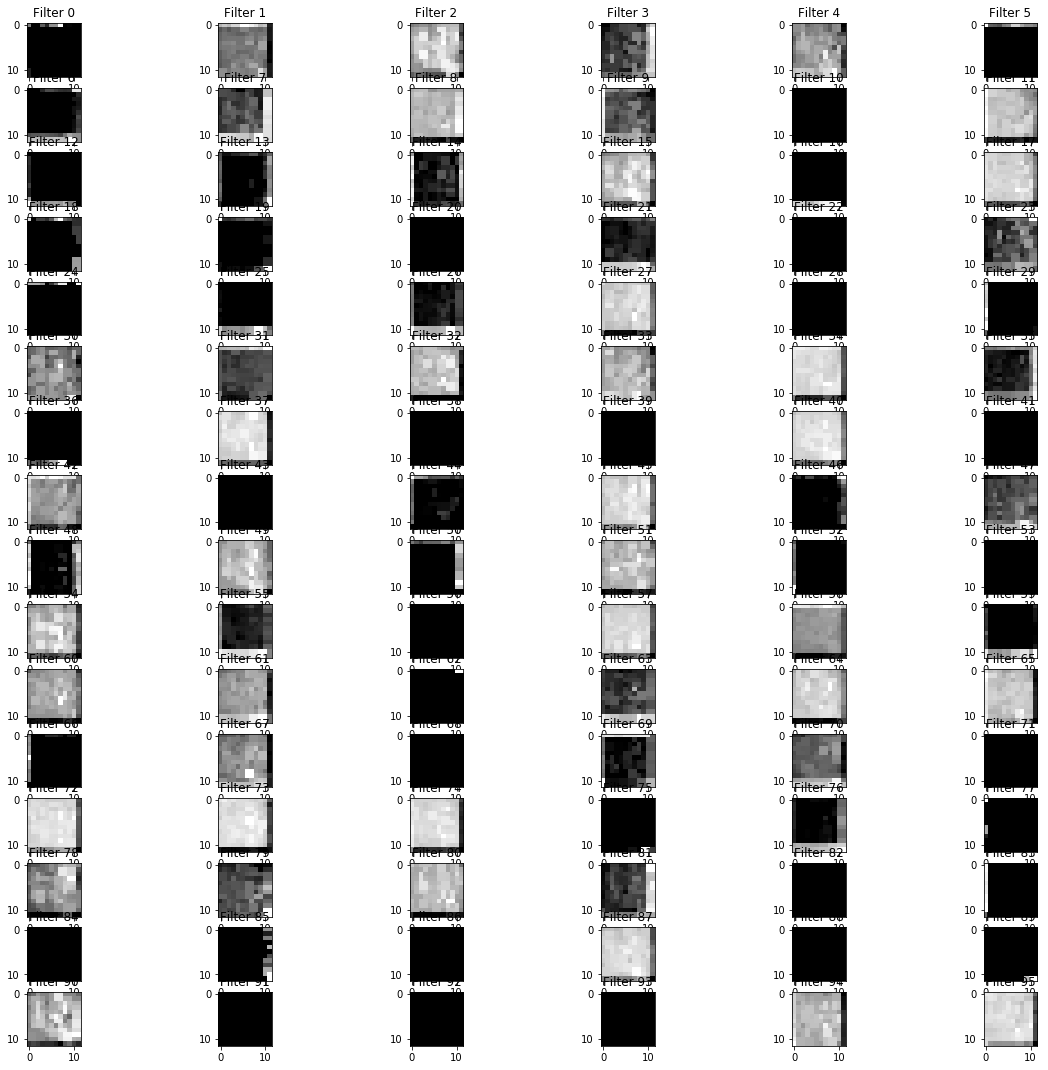

In [40]:
getActivations(sess,pool1,images_test)

In [58]:
## Check the shape of different layers
conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3

(<tf.Tensor 'model/Relu:0' shape=(?, 24, 24, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_1:0' shape=(?, 24, 24, 160) dtype=float32>,
 <tf.Tensor 'model/Relu_2:0' shape=(?, 24, 24, 96) dtype=float32>,
 <tf.Tensor 'model/MaxPool:0' shape=(?, 12, 12, 96) dtype=float32>,
 <tf.Tensor 'model/Relu_3:0' shape=(?, 12, 12, 192) dtype=float32>,
 <tf.Tensor 'model/AvgPool:0' shape=(?, 6, 6, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_4:0' shape=(?, 12, 12, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_5:0' shape=(?, 12, 12, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_6:0' shape=(?, 6, 6, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_7:0' shape=(?, 6, 6, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_8:0' shape=(?, 6, 6, 10) dtype=float32>,
 <tf.Tensor 'model/AvgPool_1:0' shape=(?, 1, 1, 10) dtype=float32>)

## 5. More Analysis

**Plot the Imgae After Pre-Processing**

In [13]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

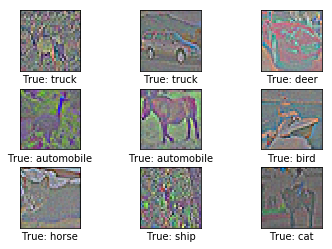

In [18]:
plot_images(images_train[1:10,:,:,:], cls_train[1:10], cls_pred=None, smooth=False)